# Flows Generation of Sweden V_ij



In [58]:
import sys
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.stats import kendalltau

In [2]:
sys.path.append('../lib/')

In [3]:
import pandas as pd
import numpy as np
import math
%load_ext autoreload
%autoreload 2

In [4]:
# Import self-defined libraries
import sweden
import netherlands
import workers
import v_ij

## 1. Load spatial zones and ground-truth data for Sweden
Check `lib\sweden.py` for what the below lines do.

In [5]:
# Initialise an object for storing the ground-truth data including zones
data_sweden = sweden.GroundTruthLoader()

# Load zones
data_sweden.load_zones()

# Create boundary for later use
data_sweden.create_boundary()

# Load ground-truth survey data into ODM form
data_sweden.load_odm()

origin_main_deso  desti_main_deso
0114A0010         0114C1170          182551.736842
                  0163C1140          810292.236111
                  0163C1170          182927.555556
                  0163C1350           94404.100629
                  0163C1380           23397.135431
Name: trip_weight, dtype: float64
ozone      dzone    
0114A0010  0114A0010    0.0
           0114C1010    0.0
           0114C1020    0.0
           0114C1030    0.0
           0114C1040    0.0
Name: trip_weight, dtype: float64


### 1.1 Check spatial zones and population

In [6]:
data_sweden.zones.head()

,zone,geometry
0,0114A0010,"POLYGON ((661116.252 6606615.603, 661171.409 6..."
1,0114C1010,"POLYGON ((666960.066 6598800.393, 666971.371 6..."
2,0114C1020,"POLYGON ((667034.814 6600076.634, 667032.984 6..."
3,0114C1030,"POLYGON ((667095.512 6599103.521, 667095.009 6..."
4,0114C1040,"POLYGON ((664610.264 6600922.821, 664638.910 6..."


In [7]:
# Load population data
data_sweden.load_population()
data_sweden.population.head()

,zone,pop
0,0114A0010,790
1,0114C1010,1608
2,0114C1020,1610
3,0114C1030,2365
4,0114C1040,2346


### 1.2 Calculate distances between zones
Figure out how you use the output data.

In [8]:
# This gives a stacked version
distances = workers.zone_distances(data_sweden.zones)

Calculating distances between zones...


In [9]:
# This gives a matrix-style dataframe
df_d = distances.unstack(level=1)
df_d.head(3)

zone,0114A0010,0114C1010,0114C1020,0114C1030,0114C1040,0114C1050,0114C1060,0114C1070,0114C1080,0114C1090,...,2584C1020,2584C1030,2584C1040,2584C1050,2584C1060,2584C1070,2584C1090,2584C1100,2584C1110,2584C1130
zone,,,,,,,,,,,,,,,,,,,,,
0114A0010,0.000000,4.795251,3.548429,4.160562,2.703179,4.783886,1.849689,2.923878,2.159032,1.674308,...,933.767042,933.828072,935.067203,935.416006,935.630309,935.620128,936.859131,936.431609,936.568693,937.598973
0114C1010,4.795251,0.000000,1.343363,0.686608,2.451822,1.246766,3.968650,2.079711,2.668393,3.291240,...,937.070798,937.137238,938.379341,938.733022,938.942200,938.922048,940.174915,939.742567,939.882250,940.918898
0114C1020,3.548429,1.343363,0.000000,0.657756,1.693341,1.362823,3.073683,0.737077,1.389539,1.969922,...,935.881658,935.947128,937.188698,937.541507,937.751603,937.733240,938.983622,938.552138,938.691355,939.726864


### 1.3 Area

In [10]:
dict_zone = dict(zip(data_sweden.zones['zone'], data_sweden.zones['geometry']))
area = dict(zip(data_sweden.zones['zone'], data_sweden.zones.area))
# change unit from m*m to km *km
for i in area.keys():
    area[i] = area[i] / 1000000
#print(area)

### 1.4 Average Radius

In [11]:
#print(data_sweden.zones.centroid)
#print(data_sweden.zones.bounds)
'''
center_x = data_sweden.zones.centroid.x.to_list()
center_y = data_sweden.zones.centroid.y.to_list()

bound_minx = data_sweden.zones.bounds.minx.to_list()
bound_miny = data_sweden.zones.bounds.miny.to_list()
bound_maxx = data_sweden.zones.bounds.maxx.to_list()
bound_maxy = data_sweden.zones.bounds.maxy.to_list()
radius = []


for i in range(0, len(center_x)):
    r1 = abs(center_x[i] - bound_minx[i])
    r2 = abs(center_x[i] - bound_maxx[i])
    r3 = abs(center_y[i] - bound_miny[i])
    r4 = abs(center_y[i] - bound_maxy[i])
    r = (r1 + r2 + r3 + r4) / 4000
    radius.append(r)


radius_dict = dict(zip(data_sweden.zones['zone'], radius))
#print(radius_dict)
'''
# Use r_average to denote r_j, which is the distance to the boundary of the location j.
# A=pi*r_average^2
r_average = []
for i in area.keys(): 
    r_average.append(math.sqrt(area[i]/math.pi))
r_average_dict = dict(zip(data_sweden.zones['zone'], r_average))
#print(r_average_dict)

### 1.5 Build ODM
Try to use numpy and pandas to get ODM. Make it align with `data_sweden.odm` which is a dataframe.

Hint: check line 51 in `sweden.py`.

In [13]:
# parameter = ln(f_max/f_min), f_min = 1/T, f_max = 1 T = 1000
'''
T = 1000
f_max = 1
f_min = 1/T
parameter = math.log(f_max / f_min)


population_density = dict(zip(data_sweden.population['zone'], data_sweden.population['pop']))
ODM_data = []

for i in data_sweden.population['zone']:
    for j in data_sweden.population['zone']:
        element = dict()
        element['origin_main_deso'] = i
        element['desti_main_deso'] = j
        if i != j:
            # filter out the error divide by zero
            element['trip_weight'] = v_ij.average_daily_trips(population_density[j], area[i], r_average_dict[j], df_d[i][j], parameter)
        if i == j:
            element['trip_weight'] = 0
        ODM_data.append(element)
ODM = pd.DataFrame(ODM_data)
'''

"\nT = 1000\nf_max = 1\nf_min = 1/T\nparameter = math.log(f_max / f_min)\n\n\npopulation_density = dict(zip(data_sweden.population['zone'], data_sweden.population['pop']))\nODM_data = []\n\nfor i in data_sweden.population['zone']:\n    for j in data_sweden.population['zone']:\n        element = dict()\n        element['origin_main_deso'] = i\n        element['desti_main_deso'] = j\n        if i != j:\n            # filter out the error divide by zero\n            element['trip_weight'] = v_ij.average_daily_trips(population_density[j], area[i], r_average_dict[j], df_d[i][j], parameter)\n        if i == j:\n            element['trip_weight'] = 0\n        ODM_data.append(element)\nODM = pd.DataFrame(ODM_data)\n"

### use $v^{tot}_{ij}$ to form the ODM

In [14]:
# parameter = ln(f_max/f_min), f_min = 1/T, f_max = 1 T = 1000
T = 1000
f_max = 1
f_min = 1/T
parameter = math.log(f_max / f_min)


population_density = dict(zip(data_sweden.population['zone'], data_sweden.population['pop']))
ODM_data = []

for i in data_sweden.population['zone']:
    for j in data_sweden.population['zone']:
        element = dict()
        element['origin_main_deso'] = i
        element['desti_main_deso'] = j
        if i != j:
            # filter out the error divide by zero
            element['trip_weight'] = v_ij.average_daily_trips(population_density[j], area[i], r_average_dict[j], df_d[i][j], parameter) + v_ij.average_daily_trips(population_density[i], area[j], r_average_dict[i], df_d[i][j], parameter)
        if i == j:
            element['trip_weight'] = 0
        ODM_data.append(element)
ODM_tot = pd.DataFrame(ODM_data)

### Get model probability

In [26]:
probability_model = ODM_tot["trip_weight"]
sum_model = probability_model.sum()
probability_model = probability_model.map(lambda x: x / sum_model)
# tranform to numpy ndarray
probability_model = probability_model.values

### Get survey probability

In [43]:
probability_survey = data_sweden.odm.values

In [44]:
print(probability_model)
print(probability_survey)

[0.00000000e+00 1.57301242e-07 4.77663734e-07 ... 3.86114893e-08
 7.49428389e-08 0.00000000e+00]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 4.83666053e-05]


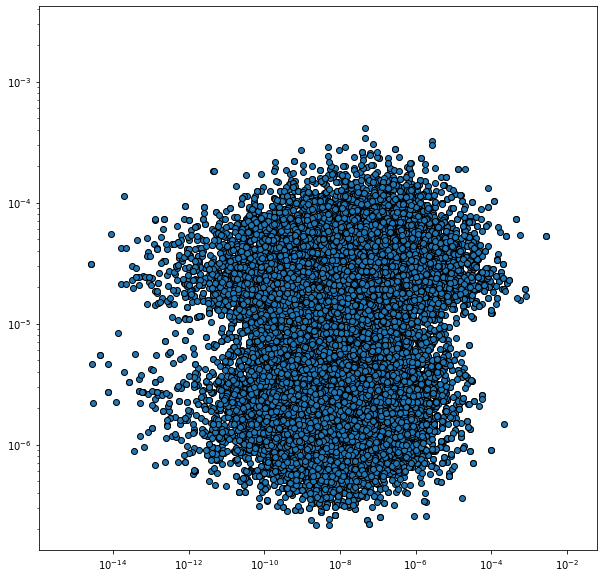

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.xscale('log')
plt.yscale('log')
ax.scatter(probability_model, probability_survey, facecolor='C0', edgecolor='k');

### get spearmanr

In [56]:
coef, p = spearmanr(probability_model, probability_survey)
alpha = 0.05

print("Spearmans correlation coefficient: %.3f" % coef)
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p )

Spearmans correlation coefficient: 0.037
Samples are correlated (reject H0) p=0.000


### get kendalltau

In [59]:
coef, p = kendalltau(probability_model, probability_survey)
alpha = 0.05

print("Spearmans correlation coefficient: %.3f" % coef)
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p )

Spearmans correlation coefficient: 0.030
Samples are correlated (reject H0) p=0.000


C:\Users\cheng\anaconda3\envs\geolab\lib\site-packages\scipy\stats\_stats_py.py:4868: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


### SSI

In [63]:
model_sum = np.sum(probability_model)
survey_sum = np.sum(probability_survey)

numerator = 0
denominator = 0

for i in range(0, len(probability_survey)):
    v_model = probability_model[i]
    v_survey = probability_survey[i]

    numerator  = numerator + min(v_survey, v_model)

denominator = model_sum + survey_sum

SSI = 2 * numerator / denominator
print(SSI)

0.018394250352296963
